# Magic Personality Matcher

## Grupo Onyrix

> Mario Vila Comesaña, Jesús Guimeráns Cordeiro, Javier Veloso Boubeta y Tania Guijarro Villavicencio

En este notebook se realiza:
- Preprocesamiento
- Entrenamiento
- Estadísticas del modelo
- Guardado del modelo
- Pruebas: clasificación de textos según su personalidad
- Valoraciones
- Mejoras del modelo

# Preprocesamiento de datos

Para evitar tener que preprocesar los datos cada vez que abrimos el Google Colab vamos a realizar tanto particionado de los datos como su preprocesamiento en este notebook aparte.

## Cargar el dataset

Lo primero es cargar el dataset con Pandas y seleccionar la cantidad de filas que queremos usar:

In [13]:
import pandas as pd

df = pd.read_csv("dataset_definitivo.csv")
print(df['personality'].value_counts())

1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
15    2000
16    2000
Name: personality, dtype: int64


## Filtrado de Stopwords, Tokenización y Stemming

El preprocesamiento de texto se realiza usando las stopwords y el tokenizer de la librería de lenguaje natural de Python. Primero definimos las stopwords, que serán las de la librería de Python y las personalidades Myers-Briggs para evitar introducir sesgos, como que, si se menciona una personalidad, que esta no se tenga en cuenta para decidir la del autor. Luego se usa el PorterStemmer para obtener la “raíz” de las palabras. Entonces el resultado es una nueva columna que contiene los posts preprocesados.

In [14]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
from multiprocessing import cpu_count
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()


STOPS = set(stopwords.words("english"))
CUSTOM_STOPS = set(['istj', 'isfj', 'infj', 'intj',
                    'istp', 'isfp', 'infp', 'intp',
                    'estp', 'esfp', 'enfp', 'entp',
                    'estj', 'esfj', 'enfj', 'entj'])

def process_text(post):
    try:
        post = post.lower()
        post = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',post) # filtrar links
        post = re.sub('[0-9]+',' ',post) # filtrar numeros
        post = re.sub('@[^\s]+',' ',post) # filtrar menciones de Twitter
        #post = re.sub('[^0-9a-z]',' ',post) # dejamos los carácteres especiales, pueden ser emojis con significado emocional
        post = re.sub('[a-z]{1,2,3}', ' ', post) # filtrar monogramas, bigramas y trigramas
        return " ".join(
            [ps.stem(w) for w in word_tokenize(post)
             if not w in STOPS and w not in CUSTOM_STOPS])
    except:
        print("problem with: ", post)


num_processes = cpu_count()

df['processed_text'] = process_map(
                    process_text, df['post'],
                    max_workers=num_processes, chunksize=10)

print(df['personality'].value_counts())

[nltk_data] Downloading package punkt to /home/mario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/32000 [00:00<?, ?it/s]

1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
15    2000
16    2000
Name: personality, dtype: int64


## Selección de filas

Eliminamos la columna de posts sin preprocesar para ahorrar memoria y las cadenas con entradas de menos de 10 carácteres.

In [15]:
# eliminar columna de posts sin preprocesar (ahorramos memoria)
df.drop('post', axis=1, inplace=True)
# eliminar entradas con cadenas pequeñas
df = df[df['processed_text'].apply(lambda x: len(x) > 10)]
print(df['personality'].value_counts())

1     1910
4     1910
5     1910
13    1909
15    1906
3     1904
11    1898
7     1897
10    1896
12    1894
2     1886
16    1877
9     1867
6     1857
8     1850
14    1846
Name: personality, dtype: int64


Ahora para tener unos datos equilibrados, aprovechando que tenemos tantos podemos seleccionar solo 5000 de cada tipo.

## División del dataset en entrenamiento, validación y test

60% entrenamiento, 20% validación y 20% test

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['personality'], test_size=0.4, random_state=42) 
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f"x_train: {len(x_train)}")
print(f"x_test: {len(x_test)}")
print(f"x_valid: {len(x_valid)}")

x_train: 18130
x_test: 6044
x_valid: 6043


## Bag of Words

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Datos de entrenamiento
bagOfWordsModel = TfidfVectorizer()
x_train = bagOfWordsModel.fit_transform(x_train)
print("x_train bag of words:")
print(x_train.shape)

# Datos pruebas
x_test = bagOfWordsModel.transform(x_test)
print("x_test bag of words:")
print(x_test.shape)

# Datos pruebas
x_valid = bagOfWordsModel.transform(x_valid)
print("x_valid bag of words:")
print(x_valid.shape)

x_train bag of words:
(18130, 18473)
x_test bag of words:
(6044, 18473)
x_valid bag of words:
(6043, 18473)


Como ya se ha aplicado el Bag of Words a todos los datos que vamos a usar se puede guardar en un fichero, que posteriormente usaremos para desplegar el modelo en el backend

In [6]:
import joblib as jb

jb.dump(bagOfWordsModel, "bow.lzma")
del bagOfWordsModel

## Reducción de dimensionalidad

In [18]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3000, random_state=42)
x_train = svd.fit_transform(x_train)

print(x_train.shape)

(18130, 3000)


Se guarda la instancia de `svd` para usarla más tarde y se borra para ahorrar memoria. Esta instancia debe guardarse por recomendación de los desarralladores, que recomiendan usar la misma instancia para todas las transformaciones, ya que sino los resultados podrían ser inconsistentes.

In [8]:
import joblib as jb

jb.dump(svd, "svd.lzma")
del svd

# Entrenamiento


## Hiperparámetros

Para obtener los mejores parámetros de entrenamiento se realizarán pruebas con distintos valores.

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 300, 500],
    'max_depth': [3, 5, 7]
}

model = HistGradientBoostingClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=2)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 7, 'max_iter': 500}


In [10]:
svd = jb.load("svd.lzma")
x_test = svd.transform(x_test)

              precision    recall  f1-score   support

           1       0.19      0.19      0.19       355
           2       0.29      0.21      0.25       405
           3       0.18      0.21      0.19       364
           4       0.18      0.23      0.20       392
           5       0.13      0.14      0.13       399
           6       0.18      0.18      0.18       382
           7       0.18      0.14      0.16       388
           8       0.14      0.11      0.13       390
           9       0.16      0.17      0.17       373
          10       0.15      0.19      0.17       362
          11       0.13      0.16      0.15       382
          12       0.20      0.20      0.20       384
          13       0.18      0.17      0.17       378
          14       0.30      0.17      0.22       383
          15       0.17      0.19      0.18       349
          16       0.13      0.15      0.14       358

    accuracy                           0.18      6044
   macro avg       0.18   

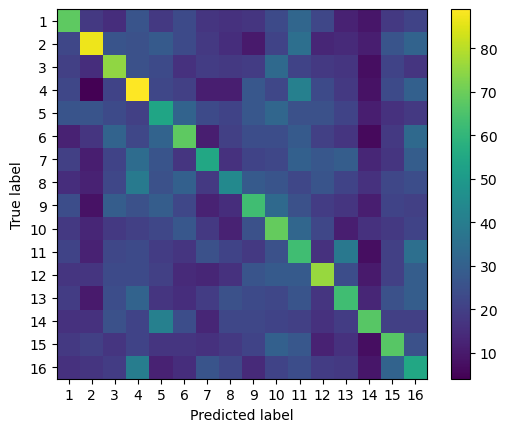

In [11]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

model = grid_search.best_estimator_

predictions = model.predict(x_test)
print(classification_report(y_test,predictions))
ConfusionMatrixDisplay.from_predictions(y_test,predictions,
                                        include_values=False)
plt.show()

In [12]:
import joblib as jb

jb.dump(model, "model.lzma")

['model.lzma']

# Ejemplo de predicciones

Para hacer predicciones necesitamos los diccionarios para convertir personalidades a números y viceversa. Replicaremos este proceso en nuestro backend para usar el modelo en la interfaz web.

In [1]:
num_personality = {
    1: 'ISTJ',
    2: 'ISFJ',
    3: 'INFJ',
    4: 'INTJ',
    5: 'ISTP',
    6: 'ISFP',
    7: 'INFP',
    8: 'INTP',
    9: 'ESTP',
    10: 'ESFP',
    11: 'ENFP',
    12: 'ENTP',
    13: 'ESTJ',
    14: 'ESFJ',
    15: 'ENFJ',
    16: 'ENTJ'
}
personality_num = {
    'ISTJ': 1,
    'ISFJ': 2,
    'INFJ': 3,
    'INTJ': 4,
    'ISTP': 5,
    'ISFP': 6,
    'INFP': 7,
    'INTP': 8,
    'ESTP': 9,
    'ESFP': 10,
    'ENFP': 11,
    'ENTP': 12,
    'ESTJ': 13,
    'ESFJ': 14,
    'ENFJ': 15,
    'ENTJ': 16
}


Se cargan para el preprocesado el bag of words y la instancia de Truncated SVD, que por recomendación de los desarrolladores, para obtener resultados más consistentes conviene usar la misma instancia para realizar todas las reducciones de dimensionalidad. Y luego se carga el modelo entrenado, que se usará para hacer las predicciones.

In [11]:
import pandas as pd
import joblib as jb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import HistGradientBoostingClassifier
from tqdm.contrib.concurrent import process_map
from nltk.stem import PorterStemmer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

bow: TfidfVectorizer = jb.load("bow.lzma")
svd: TruncatedSVD = jb.load("svd.lzma")
model: HistGradientBoostingClassifier = jb.load("model.lzma")

nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()


STOPS = set(stopwords.words("english"))
CUSTOM_STOPS = set(['istj', 'isfj', 'infj', 'intj',
                    'istp', 'isfp', 'infp', 'intp',
                    'estp', 'esfp', 'enfp', 'entp',
                    'estj', 'esfj', 'enfj', 'entj'])

def process_text(post):
    try:
        post = post.lower()
        post = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',post) # filtrar links
        post = re.sub('[0-9]+',' ',post) # filtrar numeros
        post = re.sub('@[^\s]+',' ',post) # filtrar menciones de Twitter
        #post = re.sub('[^0-9a-z]',' ',post) # dejamos los carácteres especiales, pueden ser emojis con significado emocional
        post = re.sub('[a-z]{1,2,3}', ' ', post) # filtrar monogramas, bigramas y trigramas
        return " ".join(
            [ps.stem(w) for w in word_tokenize(post)
             if not w in STOPS and w not in CUSTOM_STOPS])
    except:
        print("problem with: ", post)

[nltk_data] Downloading package punkt to /home/mario/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Para las pruebas hacemos un array con los textos `x_prueba`. Aplicamos el preprocesado con la función `process_text`, el bag of words y por último reducción de dimensionalidad con TruncatedSVD. Finalmente hacemos las predicciones sobre esas frases y convertirmos los resultados numéricos a etiquetas de Myers-Briggs usando el diccionario.

In [12]:
import numpy as np
x_prueba = [
    'this is a serious job, we are not making it about the Winx Club',
    'i am not gay, i only like eurovision',
    'i like playling league of legends'
]


x_prueba = process_map(process_text, x_prueba)
print(x_prueba)

x_prueba = bow.transform(x_prueba)
x_prueba = svd.transform(x_prueba)


predictions = model.predict(x_prueba)
print([num_personality[x] for x in predictions])

  0%|          | 0/3 [00:00<?, ?it/s]

['seriou job , make winx club', 'gay , like eurovis', 'like playl leagu legend']
['ENFJ', 'ESTP', 'ENFP']


# Sistema de valoraciones

Investigamos como hacer un sistema capaz de aprender con las valoraciones enviadas por usuarios, para ello investigamos varios enfoques.

1. Agregar nuevas entradas al modelo ya entrenado haciendo `model.fit(x_nuevos_datos)`, pero esto no funcionaría correctamente, ya que como los modelos que hemos probado se basan en árboles de decisión, las ramas creadas quedarían al final del árbol y por tanto prevalecerían las ramas creadas con los datos de entrenamiento. Además, podría provocarse overfitting, lo que empeoraría el desempeño del modelo.
2. Volver al entrenar el modelo completo agregando cada vez más datos, esto supone un problema de escalabilidad, ya que la complejidad del modelo podría aumentar demasiado, creando así una situación de overifitting. También habría que tener en cuenta que los tiempos de entrenamiento aumentarían según aumenta la cantidad de datos.
3. Usar un modelo de Active Learning, en concreto probamos [modAL](https://github.com/modAL-python/modAL). Esta librería ofrece algoritmos de selección de datos relevantes para entrenamiento, es decir, se filtrarían las valoraciones para usar solo las más relevantes para el modelo y este podría aprender de manera correcta sin necesidad de entrenarlo con todo el dataset inicial más las valoraciones. Sin embargo, obtuvimos problemas que no pudimos solucionar.

Dejamos aquí nuestro intento de usar [modAL](https://github.com/modAL-python/modAL) siguiendo su tutorial básico:

In [20]:
from modAL.models import ActiveLearner
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

x_valoraciones = [
    'this is a serious job, we are not making it about the Winx Club',
    'i am not gay, i only like eurovision',
    'i like playling league of legends'
]

x_valoraciones = process_map(process_text, x_valoraciones)
x_valoraciones = bow.transform(x_valoraciones)
x_valoraciones = svd.transform(x_valoraciones)

y_valoraciones = ['ISTP', 'ENFJ', 'INTJ']

y_valoraciones = np.array([ personality_num[x] for x in y_valoraciones ])

learner = ActiveLearner(
    estimator=HistGradientBoostingClassifier(),
    X_training=x_train, y_training=y_train
)


  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
query_idx, query_inst = learner.query(x_valoraciones)

print(f"query_idx: {query_idx}")
print(f"query_inst: {query_inst}")
print(f"y_valoraciones: {y_valoraciones}")
print(f"y_valoraciones seleccionadas: {y_valoraciones[query_idx]}")

learner.teach(query_inst, y_valoraciones[query_idx])

query_idx: [2]
query_inst: [[ 0.11122351 -0.1208835   0.1673704  ...  0.00600348 -0.0124741
   0.00161109]]
y_valoraciones: [ 5 15  4]
y_valoraciones seleccionadas: [4]


TypeError: <class 'pandas.core.series.Series'> datatype is not supported

No entendemos el error porque para las pruebas en ningún momento usamos Pandas, trabajamos solo con arrays de Numpy.

# ¿Cómo mejorar el modelo?

El resultado del modelo es bastante pobre, eso se debe a multiples factores:

1. Aunque tenemos una gran cantidad de datos, llegando a más de 1M de entradas, por limitaciones de tiempo y de hardware no podemos pasar de 150k, ya que la reducción de dimensionalidad con `TruncatedSVD`, aunque es más eficiente en memoria que `PCA`, dependiendo del número de componentes especificados puede llenar rápidamente la RAM.
2. La clasificación es compleja, usamos una clasificación en 16 tipos de personalidad, lo que requiere trabajar con más datos y dificulta bastante el conseguir buenos resultados para todos los tipos.
3. Pocos datos de algunos tipos, pese a tener tantas entradas, hay ciertas personalidades de las que falta información y esta desigualdad provoca imprecisión.

## Primer escenario de mejora - Mejor hardware

Un primer posible escenario para mejorar sería realizar un entrenamiento con hardware más potente, especialmente RAM, que permita incluir en la reducción de dimensionalidad más componentes, buscando así un valor óptimo, que según nuestras pruebas con muestras de datos pequeñas sería alrededor de 5000 componentes. Y un modelo con más datos podría realizar en general mejores predicciones.

## Segundo escenario de mejora - Cambio de enfoque

El problema de clasificación de las personalidades usando Myers-Briggs se puede abordar tratando cada rasgo de personalidad (introvertido/extrovertido, sensible/intuitivo, sentimental/pensativo, juicioso/perceptivo) por separado, clasificando los textos de forma binaria entre estos rasgos y combinarlos para obtener la personalidad completa. Por tanto, el resultado sería la combinación de 4 modelos, cada uno especializado en clasificación binaria de uno de los rasgos.

También podríamos optar por tratar esto como un problema de regresión, es decir, que cada rasgo de personalidad sea una variable continua. Por ejemplo, podríamos pensar en el rato introvertido/extrovertido como una variable continua con valores entre -1 y 1, en la que -1 signifique 100% introvertido y 1 100% extrovertido. El resultado serían 4 modelos de regresión encargados de determinar un número entre -1 y 1 entre los valores de un rasgo de personalidad. Esto se podría presentar al usuario como su personalidad de Myers-Briggs con el añadido de un porcentaje asociado a cada rasgo, siendo por ejemplo que, un usuario pueda ser 67% extrovertido, 80% intuitivo, 52% sentimental y 90% juicioso.